#### Notes on current version:
**Done**:

- $\checkmark$ Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!

**To do:**
  
- Implement Regression

- Implement Feature Map

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
# Robustness Parameter
robustness_parameter = .1

# Reconfiguration Parameters
N_Reconfigurations = 1
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = 1

# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 200

# Depth & Height of first Reconfiguration
Initial_Depth = 20
Initial_Height = 5

# Depth & Height Per Reconfiguration
Depth_per_reconfig = 10
Height_per_reconfig = 5

# Number of Datapoints
N_data = 10**3
Train_step_proportion = .7


# Unknown Function
def unknown_f(x):
    return .1*x + .1*(x**2) + np.exp(-np.abs(x)) + np.sin(4*x + x% 2) + x % 1

### Run External/Auxiliary Notebooks

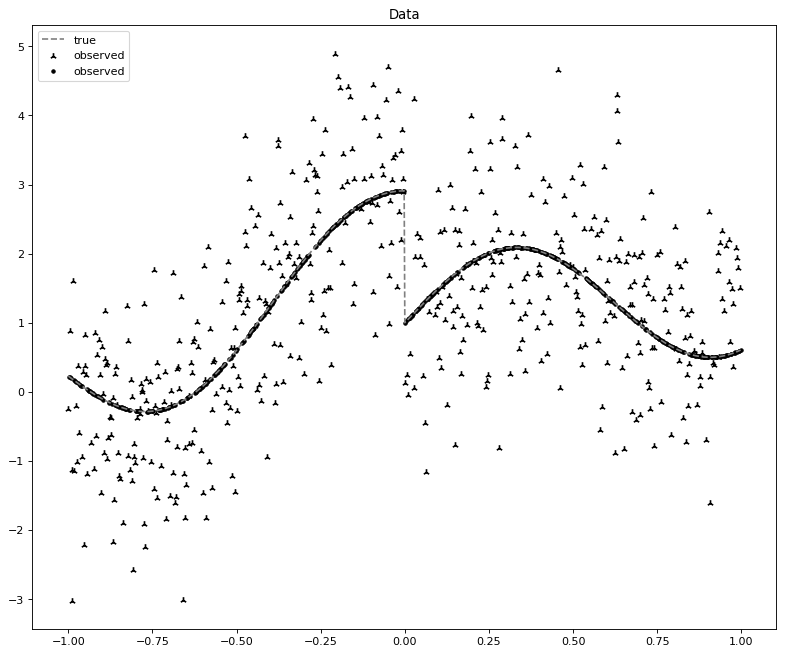

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=200,
                                                height=100,
                                                depth=10,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/200
16/16 [==============================] - 0s 4ms/step - loss: 1.2319 - mse: 2.3571 - mae: 1.2319 - mape: 241.8355
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 1.1865 - mse: 2.1668 - mae: 1.1865 - mape: 268.4331
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 1.0663 - mse: 1.8174 - mae: 1.0663 - mape: 215.8683
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 1.0641 - mse: 1.7662 - mae: 1.0641 - mape: 201.8920
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 1.0157 - mse: 1.5814 - mae: 1.0157 - mape: 175.2029
Epoch 6/200
16/16 [==============================] - 0s 5ms/step - loss: 1.0235 - mse: 1.6414 - mae: 1.0235 - mape: 210.7288
Epoch 7/200
16/16 [==============================] - 0s 5ms/step - loss: 1.0047 - mse: 1.5866 - mae: 1.0047 - mape: 203.4179
Epoch 8/200
16/16 [==============================] - 0s 4ms/step - loss

16/16 [==============================] - 0s 3ms/step - loss: 0.9683 - mse: 1.4841 - mae: 0.9683 - mape: 176.0050
Epoch 65/200
16/16 [==============================] - 0s 3ms/step - loss: 0.9833 - mse: 1.5181 - mae: 0.9833 - mape: 192.5254
Epoch 66/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9344 - mse: 1.3991 - mae: 0.9344 - mape: 168.8786
Epoch 67/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9561 - mse: 1.4374 - mae: 0.9561 - mape: 186.8183
Epoch 68/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9441 - mse: 1.4189 - mae: 0.9441 - mape: 179.2885
Epoch 69/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9435 - mse: 1.3914 - mae: 0.9435 - mape: 191.2708
Epoch 70/200
16/16 [==============================] - 0s 3ms/step - loss: 0.9502 - mse: 1.4340 - mae: 0.9502 - mape: 187.3392
Epoch 71/200
16/16 [==============================] - 0s 3ms/step - loss: 0.9448 - mse: 1.4018 - mae: 0.9448 - mape: 196.3179
Epoch

16/16 [==============================] - 0s 3ms/step - loss: 0.9372 - mse: 1.3926 - mae: 0.9372 - mape: 188.7541
Epoch 129/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9366 - mse: 1.3892 - mae: 0.9366 - mape: 178.9468
Epoch 130/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9433 - mse: 1.3841 - mae: 0.9433 - mape: 195.3214
Epoch 131/200
16/16 [==============================] - 0s 3ms/step - loss: 0.9511 - mse: 1.4256 - mae: 0.9511 - mape: 203.7898
Epoch 132/200
16/16 [==============================] - 0s 3ms/step - loss: 0.9471 - mse: 1.4200 - mae: 0.9471 - mape: 196.1156
Epoch 133/200
16/16 [==============================] - 0s 3ms/step - loss: 0.9348 - mse: 1.3677 - mae: 0.9348 - mape: 186.5574
Epoch 134/200
16/16 [==============================] - 0s 3ms/step - loss: 0.9344 - mse: 1.3722 - mae: 0.9344 - mape: 201.3301
Epoch 135/200
16/16 [==============================] - 0s 3ms/step - loss: 0.9394 - mse: 1.4005 - mae: 0.9394 - mape: 184.291

16/16 [==============================] - 0s 4ms/step - loss: 0.9085 - mse: 1.3048 - mae: 0.9085 - mape: 185.3147
Epoch 193/200
16/16 [==============================] - 0s 5ms/step - loss: 0.8995 - mse: 1.2562 - mae: 0.8995 - mape: 174.1783
Epoch 194/200
16/16 [==============================] - 0s 7ms/step - loss: 0.9320 - mse: 1.3351 - mae: 0.9320 - mape: 200.5192
Epoch 195/200
16/16 [==============================] - 0s 5ms/step - loss: 0.8941 - mse: 1.2383 - mae: 0.8941 - mape: 179.8725
Epoch 196/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9056 - mse: 1.2801 - mae: 0.9056 - mape: 185.6242
Epoch 197/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9044 - mse: 1.2604 - mae: 0.9044 - mape: 184.8948
Epoch 198/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9064 - mse: 1.3069 - mae: 0.9064 - mape: 181.1133
Epoch 199/200
16/16 [==============================] - 0s 4ms/step - loss: 0.9361 - mse: 1.3835 - mae: 0.9361 - mape: 193.512

## Get base regression model for NEU

In [6]:
if os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS_test = regression_basic.predict(data_x_test)

Pre-trained benchmark model does not exist: Training.
Epoch 1/200
16/16 - 0s - loss: 68.3595 - mse: 1.1789 - mae: 0.6172 - mape: 129.0694
Epoch 2/200
16/16 - 0s - loss: 68.1947 - mse: 1.0922 - mae: 0.5964 - mape: 133.6076
Epoch 3/200
16/16 - 0s - loss: 67.9995 - mse: 1.0171 - mae: 0.5700 - mape: 120.1812
Epoch 4/200
16/16 - 0s - loss: 67.5657 - mse: 0.8256 - mae: 0.5129 - mape: 100.4797
Epoch 5/200
16/16 - 0s - loss: 67.6227 - mse: 0.8372 - mae: 0.5212 - mape: 106.1280
Epoch 6/200
16/16 - 0s - loss: 67.4706 - mse: 0.7779 - mae: 0.5007 - mape: 104.2301
Epoch 7/200
16/16 - 0s - loss: 67.5218 - mse: 0.8147 - mae: 0.5067 - mape: 89.3095
Epoch 8/200
16/16 - 0s - loss: 67.4088 - mse: 0.7675 - mae: 0.4916 - mape: 94.9348
Epoch 9/200
16/16 - 0s - loss: 67.3338 - mse: 0.7360 - mae: 0.4816 - mape: 90.2361
Epoch 10/200
16/16 - 0s - loss: 67.4627 - mse: 0.7836 - mae: 0.4992 - mape: 85.3543
Epoch 11/200
16/16 - 0s - loss: 67.3336 - mse: 0.7325 - mae: 0.4818 - mape: 78.2938
Epoch 12/200
16/16 - 0s -

Epoch 98/200
16/16 - 0s - loss: 67.2531 - mse: 0.7023 - mae: 0.4709 - mape: 93.9976
Epoch 99/200
16/16 - 0s - loss: 67.2696 - mse: 0.7027 - mae: 0.4734 - mape: 100.2178
Epoch 100/200
16/16 - 0s - loss: 67.3173 - mse: 0.7168 - mae: 0.4801 - mape: 96.5896
Epoch 101/200
16/16 - 0s - loss: 67.3212 - mse: 0.7130 - mae: 0.4809 - mape: 97.5485
Epoch 102/200
16/16 - 0s - loss: 67.2145 - mse: 0.6888 - mae: 0.4656 - mape: 89.8928
Epoch 103/200
16/16 - 0s - loss: 67.2158 - mse: 0.6869 - mae: 0.4659 - mape: 93.8538
Epoch 104/200
16/16 - 0s - loss: 67.2115 - mse: 0.6855 - mae: 0.4653 - mape: 92.0878
Epoch 105/200
16/16 - 0s - loss: 67.2201 - mse: 0.6866 - mae: 0.4666 - mape: 92.8953
Epoch 106/200
16/16 - 0s - loss: 67.2736 - mse: 0.7073 - mae: 0.4738 - mape: 94.6385
Epoch 107/200
16/16 - 0s - loss: 67.2146 - mse: 0.6819 - mae: 0.4660 - mape: 94.1960
Epoch 108/200
16/16 - 0s - loss: 67.2402 - mse: 0.6910 - mae: 0.4695 - mape: 96.4367
Epoch 109/200
16/16 - 0s - loss: 67.2241 - mse: 0.6875 - mae: 0.46

Epoch 195/200
16/16 - 0s - loss: 67.2039 - mse: 0.6800 - mae: 0.4644 - mape: 95.5723
Epoch 196/200
16/16 - 0s - loss: 67.2254 - mse: 0.6842 - mae: 0.4675 - mape: 95.5349
Epoch 197/200
16/16 - 0s - loss: 67.2242 - mse: 0.6872 - mae: 0.4672 - mape: 92.5311
Epoch 198/200
16/16 - 0s - loss: 67.2175 - mse: 0.6874 - mae: 0.4661 - mape: 96.3015
Epoch 199/200
16/16 - 0s - loss: 67.2047 - mse: 0.6820 - mae: 0.4644 - mape: 92.0009
Epoch 200/200
16/16 - 0s - loss: 67.2289 - mse: 0.6925 - mae: 0.4676 - mape: 96.9347
Base Regressor-Model: Saving
INFO:tensorflow:Assets written to: ./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/assets
Base Regressor-Model: Saved


### Generate Plots - Visualization

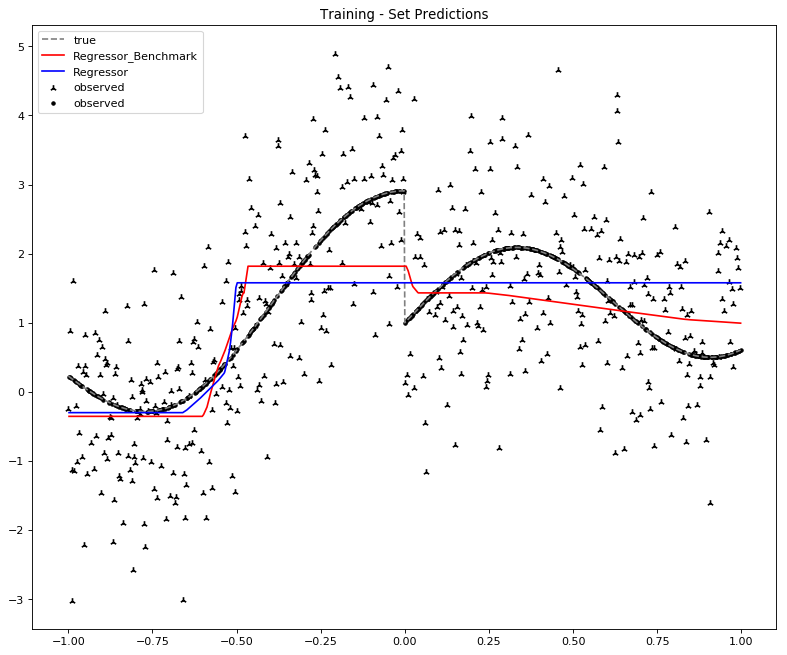

In [7]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='Regressor_Benchmark')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [8]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained model does not exist: Training.
1.7480626315642427
1.0
Complete: Pre-Training Readout Map on Input x Output Space!
Saving Pre-Trained Readout on Input x Output Space!
INFO:tensorflow:Assets written to: ./outputs/models/NEU/Greedy_Initializations/assets
(Full-)Model does not exist: Training.
Epoch 1/200
16/16 [==============================] - 0s 3ms/step - loss: 35.3306 - mse: 1.4738 - mae: 0.9621
Epoch 2/200
16/16 [==============================] - 0s 3ms/step - loss: 35.3249 - mse: 1.4694 - mae: 0.9606
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 35.3186 - mse: 1.4647 - mae: 0.9589
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 35.3144 - mse: 1.4617 - mae: 0.9578
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 35.3097 - mse: 1.4565 - mae: 0.9566
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 35.3046 - mse: 1.4517 - mae: 0.9552
Epoch 7/200
16/16 [=======================

16/16 [==============================] - 0s 4ms/step - loss: 35.1712 - mse: 1.3427 - mae: 0.9195
Epoch 73/200
16/16 [==============================] - 0s 3ms/step - loss: 35.1689 - mse: 1.3395 - mae: 0.9190
Epoch 74/200
16/16 [==============================] - 0s 3ms/step - loss: 35.1707 - mse: 1.3403 - mae: 0.9195
Epoch 75/200
16/16 [==============================] - 0s 3ms/step - loss: 35.1729 - mse: 1.3413 - mae: 0.9201
Epoch 76/200
16/16 [==============================] - 0s 3ms/step - loss: 35.1706 - mse: 1.3413 - mae: 0.9194
Epoch 77/200
16/16 [==============================] - 0s 3ms/step - loss: 35.1736 - mse: 1.3407 - mae: 0.9204
Epoch 78/200
16/16 [==============================] - 0s 4ms/step - loss: 35.1704 - mse: 1.3401 - mae: 0.9194
Epoch 79/200
16/16 [==============================] - 0s 3ms/step - loss: 35.1705 - mse: 1.3398 - mae: 0.9195
Epoch 80/200
16/16 [==============================] - 0s 3ms/step - loss: 35.1656 - mse: 1.3368 - mae: 0.9181
Epoch 81/200
16/16 [===

16/16 [==============================] - 0s 6ms/step - loss: 35.1549 - mse: 1.3244 - mae: 0.9155
Epoch 147/200
16/16 [==============================] - 0s 5ms/step - loss: 35.1530 - mse: 1.3242 - mae: 0.9149
Epoch 148/200
16/16 [==============================] - 0s 5ms/step - loss: 35.1500 - mse: 1.3201 - mae: 0.9142
Epoch 149/200
16/16 [==============================] - 0s 6ms/step - loss: 35.1566 - mse: 1.3249 - mae: 0.9160
Epoch 150/200
16/16 [==============================] - 0s 5ms/step - loss: 35.1536 - mse: 1.3248 - mae: 0.9150
Epoch 151/200
16/16 [==============================] - 0s 6ms/step - loss: 35.1525 - mse: 1.3248 - mae: 0.9147
Epoch 152/200
16/16 [==============================] - 0s 5ms/step - loss: 35.1594 - mse: 1.3291 - mae: 0.9166
Epoch 153/200
16/16 [==============================] - 0s 5ms/step - loss: 35.1503 - mse: 1.3219 - mae: 0.9141
Epoch 154/200
16/16 [==============================] - 0s 4ms/step - loss: 35.1529 - mse: 1.3262 - mae: 0.9147
Epoch 155/200
1

### Generate Plots - Visualization

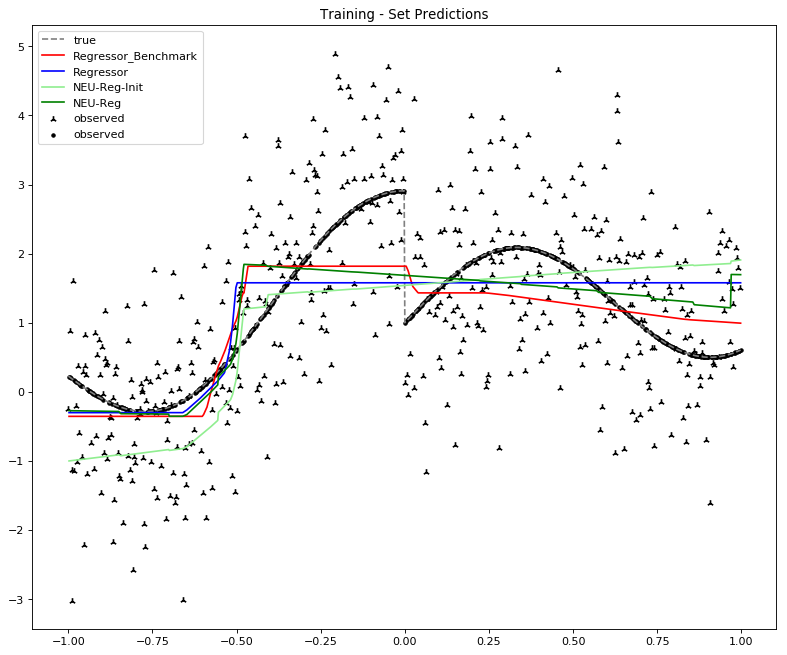

In [9]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='Regressor_Benchmark')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test.reshape(-1,)), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

---
---
---

# Benchmark Models

In [11]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
    
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

GLd-Nets Trained model already exists: Loading.
GLd-Nets trained model: Loaded.
Benchmark Model - GLd-Nets: Ready!


In [12]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Ed-Nets Model does not exist: Training.
Epoch 1/200
16/16 [==============================] - 0s 3ms/step - loss: 9.5545 - mse: 9.5545 - mae: 2.4825
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 6.5010 - mse: 6.5010 - mae: 2.0659
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 5.7628 - mse: 5.7628 - mae: 1.9381
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 5.3496 - mse: 5.3496 - mae: 1.8642
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 5.0730 - mse: 5.0730 - mae: 1.8140
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 4.8708 - mse: 4.8708 - mae: 1.7745
Epoch 7/200
16/16 [==============================] - 0s 3ms/step - loss: 4.7146 - mse: 4.7146 - mae: 1.7440
Epoch 8/200
16/16 [==============================] - 0s 3ms/step - loss: 4.5855 - mse: 4.5855 - mae: 1.7188
Epoch 9/200
16/16 [==============================] - 0s 3ms/step - loss: 4.4776 - mse: 4.4776 - 

16/16 [==============================] - 0s 3ms/step - loss: 3.1844 - mse: 3.1844 - mae: 1.4032
Epoch 76/200
16/16 [==============================] - 0s 3ms/step - loss: 3.1789 - mse: 3.1789 - mae: 1.4017
Epoch 77/200
16/16 [==============================] - 0s 3ms/step - loss: 3.1735 - mse: 3.1735 - mae: 1.4004
Epoch 78/200
16/16 [==============================] - 0s 3ms/step - loss: 3.1684 - mse: 3.1684 - mae: 1.3991
Epoch 79/200
16/16 [==============================] - 0s 3ms/step - loss: 3.1631 - mse: 3.1631 - mae: 1.3978
Epoch 80/200
16/16 [==============================] - 0s 4ms/step - loss: 3.1581 - mse: 3.1581 - mae: 1.3965
Epoch 81/200
16/16 [==============================] - 0s 3ms/step - loss: 3.1530 - mse: 3.1530 - mae: 1.3953
Epoch 82/200
16/16 [==============================] - 0s 3ms/step - loss: 3.1480 - mse: 3.1480 - mae: 1.3940
Epoch 83/200
16/16 [==============================] - 0s 2ms/step - loss: 3.1431 - mse: 3.1431 - mae: 1.3928
Epoch 84/200
16/16 [============

16/16 [==============================] - 0s 2ms/step - loss: 2.9117 - mse: 2.9117 - mae: 1.3337
Epoch 150/200
16/16 [==============================] - 0s 3ms/step - loss: 2.9093 - mse: 2.9093 - mae: 1.3331
Epoch 151/200
16/16 [==============================] - 0s 2ms/step - loss: 2.9070 - mse: 2.9070 - mae: 1.3325
Epoch 152/200
16/16 [==============================] - 0s 2ms/step - loss: 2.9049 - mse: 2.9049 - mae: 1.3318
Epoch 153/200
16/16 [==============================] - 0s 2ms/step - loss: 2.9043 - mse: 2.9043 - mae: 1.3317
Epoch 154/200
16/16 [==============================] - 0s 3ms/step - loss: 2.9040 - mse: 2.9040 - mae: 1.3316
Epoch 155/200
16/16 [==============================] - 0s 3ms/step - loss: 2.9038 - mse: 2.9038 - mae: 1.3315
Epoch 156/200
16/16 [==============================] - 0s 2ms/step - loss: 2.9034 - mse: 2.9034 - mae: 1.3314
Epoch 157/200
16/16 [==============================] - 0s 3ms/step - loss: 2.9032 - mse: 2.9032 - mae: 1.3313
Epoch 158/200
16/16 [===

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Test results.

In [13]:
# Quantile Losses 
# -----------------#
Results_MAE = np.array([np.mean(np.abs(NEU_OLS_prediction  - data_y)),
                        np.mean(np.abs(predictions_OLS[:,1]  - data_y)),
                        np.mean(np.abs(Deep_GLd_prediction  - data_y)),
                        np.mean(np.abs(Deep_Ed_prediction - data_y))])

Results_MinE = np.array([np.min(np.abs(NEU_OLS_prediction  - data_y)),
                         np.min(np.abs(predictions_OLS[:,1]  - data_y)),
                         np.min(np.abs(Deep_GLd_prediction  - data_y)),
                         np.min(np.abs(Deep_Ed_prediction - data_y))])

Results_MaxE = np.array([np.max(np.abs(NEU_OLS_prediction  - data_y)),
                         np.max(np.abs(predictions_OLS[:,1]  - data_y)),
                         np.max(np.abs(Deep_GLd_prediction  - data_y)),
                         np.max(np.abs(Deep_Ed_prediction - data_y))])

# Variance Losses
#----------------#
Results_MSE = np.array([np.mean(np.power(NEU_OLS_prediction  - data_y,2)),
                        np.mean(np.power(predictions_OLS[:,1]  - data_y,2)),
                        np.mean(np.power(Deep_GLd_prediction  - data_y,2)),
                        np.mean(np.power(Deep_Ed_prediction - data_y,2))])

# Robust Loss
#-------------#
# Robust MAE
Results_rMAE = np.array([Robust_MSE_numpy(NEU_OLS_prediction,data_y),
                         Robust_MSE_numpy(predictions_OLS[:,1],data_y),
                         Robust_MSE_numpy(Deep_GLd_prediction,data_y),
                         Robust_MSE_numpy(Deep_Ed_prediction,data_y)])

# Write to DataFrame
Results = pd.DataFrame({'MAE': Results_MAE,
                        'MinE': Results_MinE, 
                        'MaxE': Results_MaxE,
                        'Robust MAE':Results_rMAE,
                        'MSE':Results_MSE},
                        index={'NEU-OLS','OLS','Deep GLd','Deep ED'})

Test results.

In [14]:
# Quantile Losses 
#-----------------#
Results_MAE_test = np.array([np.mean(np.abs(NEU_OLS_prediction_test  - data_y_test)),
                             np.mean(np.abs(predictions_OLS_test[:,1]  - data_y_test)),
                             np.mean(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                             np.mean(np.abs(Deep_Ed_prediction_test- data_y_test))])

Results_MinE_test = np.array([np.min(np.abs(NEU_OLS_prediction_test  - data_y_test)),
                              np.min(np.abs(predictions_OLS_test[:,1]  - data_y_test)),
                              np.min(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                              np.min(np.abs(Deep_Ed_prediction_test - data_y_test))])

Results_MaxE_test = np.array([np.max(np.abs(NEU_OLS_prediction_test  - data_y_test)),
                              np.max(np.abs(predictions_OLS_test[:,1]  - data_y_test)),
                              np.max(np.abs(Deep_GLd_prediction_test  - data_y_test)),
                              np.max(np.abs(Deep_Ed_prediction_test - data_y_test))])

# Variance Losses
#----------------#
Results_MSE_test = np.array([np.mean(np.power(NEU_OLS_prediction_test  - data_y_test,2)),
                             np.mean(np.power(predictions_OLS_test[:,1]  - data_y_test,2)),
                             np.mean(np.power(Deep_GLd_prediction_test  - data_y_test,2)),
                             np.mean(np.power(Deep_Ed_prediction_test - data_y_test,2))])

# Robust Loss
#-------------#
# Robust MAE
Results_rMAE_test = np.array([Robust_MSE_numpy(NEU_OLS_prediction_test,data_y_test),
                              Robust_MSE_numpy(predictions_OLS_test[:,1],data_y_test),
                              Robust_MSE_numpy(Deep_GLd_prediction_test,data_y_test),
                              Robust_MSE_numpy(Deep_Ed_prediction_test,data_y_test)])

# Write to DataFrame
Results_test = pd.DataFrame({'MAE': Results_MAE_test,
                        'MinE': Results_MinE_test, 
                        'MaxE': Results_MaxE_test,
                        'Robust MAE':Results_rMAE_test,
                        'MSE':Results_MSE_test},
                        index={'NEU-OLS','OLS','Deep GLd','Deep ED'})

# Visualize Predictions

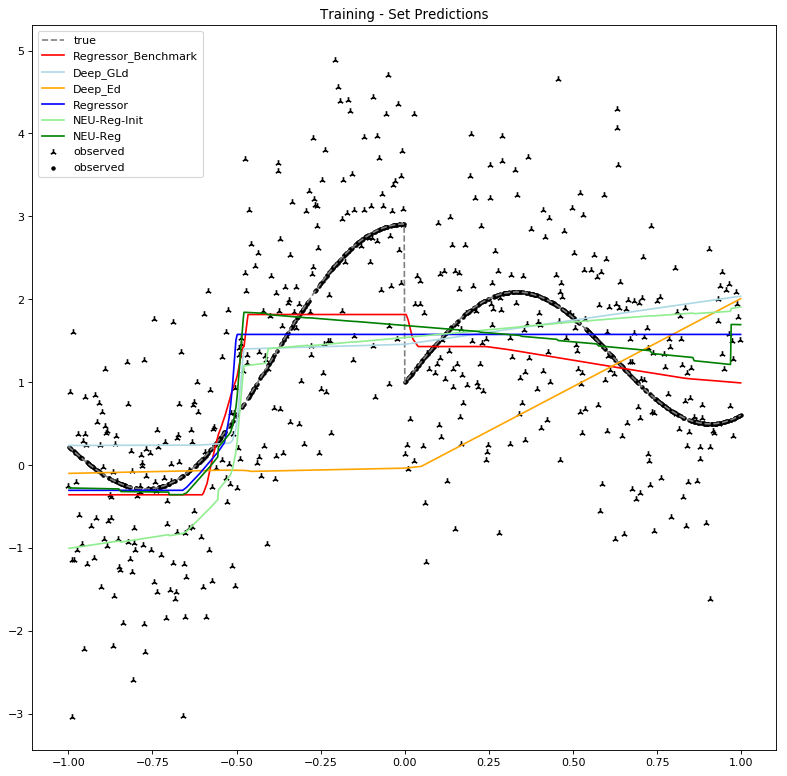

In [17]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='true',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='observed', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='observed', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='Regressor_Benchmark')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep_GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep_Ed')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='Regressor')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test.reshape(-1,)), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

 ---

# Report Results

In [18]:
print('Train Results:')
Results

Train Results:


,MAE,MinE,MaxE,Robust MAE,MSE
Deep ED,1.343052,0.000024,5.245734,1.394759,2.808639
NEU-OLS,0.932919,0.005466,3.313278,0.958781,1.376539
Deep GLd,1.285729,0.000002,5.068133,1.333003,2.574111
OLS,1.415864,0.000011,5.034333,1.471364,3.083503


In [19]:
print('Test Results:')
Results_test

Test Results:


,MAE,MinE,MaxE,Robust MAE,MSE
Deep ED,0.971540,2.932264e-08,3.263256,0.996486,1.434177
NEU-OLS,0.504641,2.984786e-06,1.331381,0.512078,0.402345
Deep GLd,0.911392,2.262363e-06,2.670101,0.932026,1.238697
OLS,1.131003,1.223908e-06,3.006726,1.162934,1.910475


#### The END